In [35]:
import os
import numpy as np
import json
import laspy
import matplotlib.pyplot as plt
from carla_dataloader import get_radar_from_path

In [36]:
def print_json(json_data):
    print(json.dumps(json_data, indent = 4, sort_keys = True))

def get_xyz(data):
    return np.array([data['x'], -data['y'], data['z']])

def get_transform(data):
    return np.array([data['pitch'], -data['yaw'], data['roll']])

def measure_distance(a, b):
    return np.linalg.norm(a - b)

def get_relative_vector(a, b):
    return b - a / measure_distance(a, b)

def get_forward_vector(transform):
    pitch = np.radians(transform[0])
    yaw = np.radians(transform[1])

    return np.array([
        np.cos(pitch) * np.cos(yaw),
        np.cos(pitch) * np.sin(yaw),
        np.sin(pitch)
    ])

In [37]:
distance_threshold = 30 # in m

attributes = {
    "vehicle": [
        "id", 
        "location", 
        "transform", 
        "bounding_box", 
        "velocity", 
        "acceleration", 
        "is_at_traffic_light", 
        "traffic_light_state", 
        "vehicle_type"
    ], 
    
    "walker": [
        "id",
        "location",
        "transform",
        "bounding_box",
        "velocity",
        "acceleration"
    ],
    
    "traffic": [
        "id",
        "location",
        "transform",
        "bounding_box",
        "type",
        "state",
        "elapsed_time",
        "affected_lane_waypoints",
        "stop_waypoints",
        "light_boxes",
        "speed_limit"
    ]
}

In [38]:
def process_fwd_back(data, object_type, ego_data, distance_threshold):
    ego_vehicle_id = ego_data["id"]
    ego_location = get_xyz(ego_data["location"])
    # ego_velocity = get_xyz(ego_data["velocity"])
    # ego_acceleration = get_xyz(ego_data["acceleration"])
    
    ego_transform = get_transform(ego_data["transform"])
    ego_forward_vector = get_forward_vector(ego_transform)
    forward_objects, backward_objects = [], []
    
    for object in data[object_type]:
        
        # Skip if object is ego vehicle
        if object["id"] == ego_vehicle_id:
            continue
        
        # get location of object
        obj_loc = get_xyz(object["location"])
        
        # Threshold Filtering
        if measure_distance(ego_location, obj_loc) > distance_threshold:
            continue
        
        if object_type == "vehicle":
            print(f"Object Location: {obj_loc}")
            print(f"Ego Location: {ego_location}")
            
            print(f"Measured Distance: {measure_distance(ego_location, obj_loc)}\n\n")
        # print(f"Diff Vector: {obj_loc - ego_location}")
        
        # Distance Vector to determine if object is in front or behind ego vehicle
        dist_vector = get_relative_vector(ego_location, obj_loc)
        
        if np.dot(ego_forward_vector, dist_vector) > 0:
            forward_objects.append(object)
        else:
            backward_objects.append(object)
    
    return forward_objects, backward_objects

def filter_vehicle_lane(ego_data, fwd_vehicles, back_vehicles, velocity_threshold):
    ego_location = get_xyz(ego_data["location"])
    ego_velocity = get_xyz(ego_data["velocity"])
    
    fwd_in_lane, back_in_lane = [], []
    fwd_out_lane, back_out_lane = [], []
    
    for vehicle in fwd_vehicles:
        vehicle_loc = get_xyz(vehicle["location"])
        vehicle_velocity = get_xyz(vehicle["velocity"])
        rel_velocity = vehicle_velocity - ego_velocity
        
        if np.linalg.norm(rel_velocity) < velocity_threshold:
            dist_vector = get_relative_vector(ego_location, vehicle_loc)
            
            vehicle_transform = get_transform(vehicle["transform"])
            vehicle_forward_vector = get_forward_vector(vehicle_transform)
            
            if np.dot(dist_vector, vehicle_forward_vector) > 0:
                fwd_in_lane.append(vehicle)
            else:
                fwd_out_lane.append(vehicle)
        
        else:
            if np.dot(ego_velocity, vehicle_velocity) > 0:
                fwd_in_lane.append(vehicle)
            else:
                fwd_out_lane.append(vehicle)
    
    for vehicle in back_vehicles:
        vehicle_loc = get_xyz(vehicle["location"])
        vehicle_velocity = get_xyz(vehicle["velocity"])
        rel_velocity = vehicle_velocity - ego_velocity
        
        if np.linalg.norm(rel_velocity) < velocity_threshold:
            dist_vector = get_relative_vector(ego_location, vehicle_loc)
            
            vehicle_transform = get_transform(vehicle["transform"])
            vehicle_forward_vector = get_forward_vector(vehicle_transform)
            
            if np.dot(dist_vector, vehicle_forward_vector) < 0:
                back_in_lane.append(vehicle)
            else:
                back_out_lane.append(vehicle)
        else:
            if np.dot(ego_velocity, vehicle_velocity) > 0:
                back_in_lane.append(vehicle)
            else:
                back_out_lane.append(vehicle)
    
    return fwd_in_lane, back_in_lane, fwd_out_lane, back_out_lane

def filter_applicable_traffic(ego_data, fwd_traffic, traffic_threshold = -0.7):
    ego_location = get_xyz(ego_data["location"])
    ego_transform = get_transform(ego_data["transform"])
    ego_forward_vector = get_forward_vector(ego_transform)
    
    fwd_applicable_traffic = []
    for traffic in fwd_traffic:
        traffic_loc = get_xyz(traffic["location"])
        traffic_transform = get_transform(traffic["transform"])
        traffic_forward_vector = get_forward_vector(traffic_transform)
        
        if np.dot(ego_forward_vector, traffic_forward_vector) < traffic_threshold:
            fwd_applicable_traffic.append(traffic)
    
    return fwd_applicable_traffic

def count_vehicles(data, ego_data, distance_threshold, bike_type_list):
    ego_id = ego_data["id"]
    ego_location = get_xyz(ego_data["location"])
    
    bike_list, car_list = [], []
    
    for vehicle in data["vehicle"]:
        if vehicle["id"] == ego_id:
            continue
        
        vehicle_loc = get_xyz(vehicle["location"])
        if measure_distance(ego_location, vehicle_loc) > distance_threshold:
            continue
        
        vehicle_desc = vehicle["vehicle_description"]
        if vehicle_desc[1] in bike_type_list or vehicle_desc[2] in bike_type_list:
            bike_list.append(vehicle)
        else:
            car_list.append(vehicle)
    
    return car_list, bike_list
        
bike_type_list = ["yamaha", "crossbike", "kawasaki", "harley-davidson", "omafiets", "diamondback", "vespa"]        

In [39]:
def plot_data(data_path, distance_threshold, total_samples = 10, velocity_threshold = 0.1):
    return_data = []
    for _ in range(total_samples):
        print(f"Working on sample {_}")
        scenarios = [f.path for f in os.scandir(data_path) if f.is_dir()]
        scenarios.sort()

        # select random scenario
        i = np.random.randint(len(scenarios))
        scenario_path = scenarios[i]

        # select town route
        towns = [f.path for f in os.scandir(scenario_path) if f.is_dir()]
        towns.sort()

        # select random town
        i = np.random.randint(len(towns))
        town_path = towns[i]

        # select route
        routes = [f.path for f in os.scandir(town_path) if f.is_dir()]
        routes.sort()

        # select random route
        i = np.random.randint(len(routes))
        example_route_path = routes[i]
        
        json_folder = os.path.join(example_route_path, "ground_truth_data")
        ego_vehicle_file = os.path.join(example_route_path, "ego_vehicle_id.txt")

        json_files = [f.path for f in os.scandir(json_folder) if f.is_file()]
        json_files.sort()

        with open(ego_vehicle_file, "r") as f:
            ego_vehicle_id = int(f.read().strip())
            
        i = np.random.randint(0, len(json_files))
        json_file_path = json_files[i]

        with open(json_file_path, "r") as f:
            data = json.load(f)
        
        ego_data = None

        for veh in data["vehicle"]:
            if veh["id"] == ego_vehicle_id:
                ego_data = veh
                break
        
        # fwd_vehicles, back_vehicles = process_fwd_back(data, "vehicle", ego_data, distance_threshold)
        # fwd_traffic, _ = process_fwd_back(data, "traffic", ego_data, distance_threshold)
        # fwd_walkers, back_walkers = process_fwd_back(data, "walker", ego_data, distance_threshold)

        # vehicle_data = filter_vehicle_lane(ego_data, fwd_vehicles, back_vehicles, velocity_threshold)
        # applicable_traffic = filter_applicable_traffic(ego_data, fwd_traffic)
        
        car_list, bike_list = count_vehicles(data, ego_data, distance_threshold, bike_type_list)
        
        rgb_path = os.path.join(example_route_path, "rgb")
        rgb_files = [f.path for f in os.scandir(rgb_path) if f.is_file()]
        rgb_files.sort()

        lidar_path = os.path.join(example_route_path, "lidar")
        lidar_files = [f.path for f in os.scandir(lidar_path) if f.is_file()]
        lidar_files.sort()

        json_file_number = int(json_file_path.split("/")[-1].split(".")[0])

        # pick the same rgb file as the json file
        for i, rgb_file in enumerate(rgb_files):
            if i == json_file_number:
                break
        
        img = plt.imread(rgb_file)
        
        lidar_file = lidar_files[i]
        read_lidar = laspy.read(lidar_file)
        lidar_points = np.vstack([read_lidar.x, read_lidar.y, read_lidar.z]).T

        radar = get_radar_from_path(example_route_path, json_file_number)
        radar = np.log(radar + 1e-30)
        
        fig, ax = plt.subplot_mosaic("AA;BC", figsize=(8,5))

        ax['A'].imshow(img, aspect='auto')
        ax['A'].set_xticks([])
        ax['A'].set_yticks([])
        ax['A'].set_axis_off()
        
        ax['B'].scatter(lidar_points[:, 1], lidar_points[:, 0], s=0.1, c=lidar_points[:, 2])
        ax['B'].set_xlim(-50, 50)
        ax['B'].set_ylim(-50, 50)
        ax['B'].set_xticks([])
        ax['B'].set_yticks([])
        ax['B'].set_axis_off()
        
        ax['C'].imshow(radar, aspect='auto')
        ax['C'].set_xticks([])
        ax['C'].set_yticks([])
        ax['C'].set_axis_off()
        plt.tight_layout()
        plt.show()
        
        print(rgb_file)
        
        if len(car_list) > 0:
            print("Cars")
            for car in car_list:
                print(car["vehicle_description"])
        
        if len(bike_list) > 0:
            print("\nBikes")
            for bike in bike_list:
                print(bike["vehicle_description"])
        
        # if len(vehicle_data[0]) > 0:
        #     print("Forward In Lane Vehicles")
        #     for veh in vehicle_data[0]:
        #         print(veh["vehicle_description"])

        # if len(vehicle_data[1]) > 0:
        #     print("\nForward Out Lane Vehicles")
        #     for veh in vehicle_data[1]:
        #         print(veh["vehicle_description"])

        # if len(vehicle_data[2]) > 0:
        #     print("\nBackward In Lane Vehicles")
        #     for veh in vehicle_data[2]:
        #         print(veh["vehicle_description"])    

        # if len(vehicle_data[3]) > 0:
        #     print("\nBackward Out Lane Vehicles")
        #     for veh in vehicle_data[3]:
        #         print(veh["vehicle_description"])

        # if len(applicable_traffic) > 0:
        #     print("\nApplicable Traffic")
        #     for traffic in applicable_traffic:
        #         if traffic["type"] == "speed_limit":
        #             print(traffic["type"], traffic["speed_limit"])
        #         elif traffic["type"] == "traffic_light":
        #             print(traffic["type"], traffic["state"])
        #         else:
        #             print(traffic["type"])
        
        # return_data.append({
        #     "rgb_file": rgb_file,
        #     "lidar_file": lidar_file,
        #     "ego": ego_data,
        #     "forward_in_lane": vehicle_data[0],
        #     "forward_out_lane": vehicle_data[1],
        #     "backward_in_lane": vehicle_data[2],# find top 5 closest vehicles
        #     "backward_out_lane": vehicle_data[3]
        # })
        
        return_data.append({
            "rgb_file": rgb_file,
            "lidar_file": lidar_file,
            "ego": ego_data,
            "cars": car_list,
            "bikes": bike_list
        })
        print("\n\n")
    return return_data

Working on sample 0


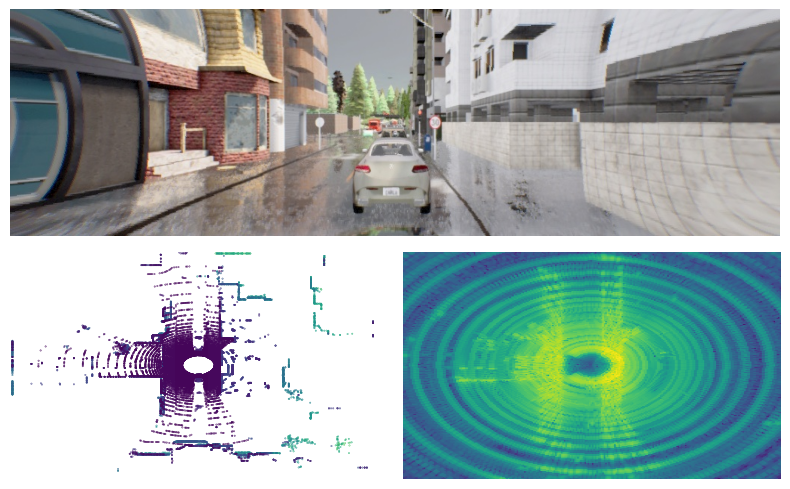

/radar-imaging-dataset/P2SIF/carla_data/s1_2025-03-05/s1_Town02_Rep0/Town02_Scenario1_route3_03_05_13_04_23/rgb/0379.jpg
Cars
['vehicle', 'mercedes-benz', 'coupe']
['vehicle', 'jeep', 'wrangler_rubicon']
['vehicle', 'nissan', 'patrol']
['vehicle', 'nissan', 'patrol']
['vehicle', 'bmw', 'isetta']
['vehicle', 'audi', 'etron']

Bikes
['vehicle', 'gazelle', 'omafiets']
['vehicle', 'bh', 'crossbike']
['vehicle', 'kawasaki', 'ninja']





In [52]:
data_path = "/radar-imaging-dataset/P2SIF/carla_data/"
return_data = plot_data(data_path = data_path, 
                 distance_threshold = 40, 
                 total_samples = 1, 
                 velocity_threshold = 0.5)

In [53]:
example_route_path = "/".join(return_data[0]["rgb_file"].split("/")[:-2])
idx = int(return_data[0]["rgb_file"].split("/")[-1].split(".")[0])

json_folder = os.path.join(example_route_path, "ground_truth_data")
ego_vehicle_file = os.path.join(example_route_path, "ego_vehicle_id.txt")

json_files = [f.path for f in os.scandir(json_folder) if f.is_file()]
json_files.sort()

with open(ego_vehicle_file, "r") as f:
    ego_vehicle_id = int(f.read().strip())
    
i = idx
json_file_path = json_files[i]

with open(json_file_path, "r") as f:
    data = json.load(f)

ego_data = None

for veh in data["vehicle"]:
    if veh["id"] == ego_vehicle_id:
        ego_data = veh
        break

# fwd_vehicles, back_vehicles = process_fwd_back(data, "vehicle", ego_data, distance_threshold = 40)
fwd_traffic, back_traffic = process_fwd_back(data, "traffic", ego_data, distance_threshold = 40)
# fwd_walkers, back_walkers = process_fwd_back(data, "walker", ego_data, distance_threshold)

# vehicle_data = filter_vehicle_lane(ego_data, fwd_vehicles, back_vehicles, 0.5)
# applicable_traffic = filter_applicable_traffic(ego_data, fwd_traffic)

car_list, bike_list = count_vehicles(data, ego_data, distance_threshold = 40, bike_type_list = bike_type_list)

rgb_path = os.path.join(example_route_path, "rgb")
rgb_files = [f.path for f in os.scandir(rgb_path) if f.is_file()]
rgb_files.sort()

lidar_path = os.path.join(example_route_path, "lidar")
lidar_files = [f.path for f in os.scandir(lidar_path) if f.is_file()]
lidar_files.sort()

json_file_number = int(json_file_path.split("/")[-1].split(".")[0])

# pick the same rgb file as the json file
for i, rgb_file in enumerate(rgb_files):
    if i == json_file_number:
        break

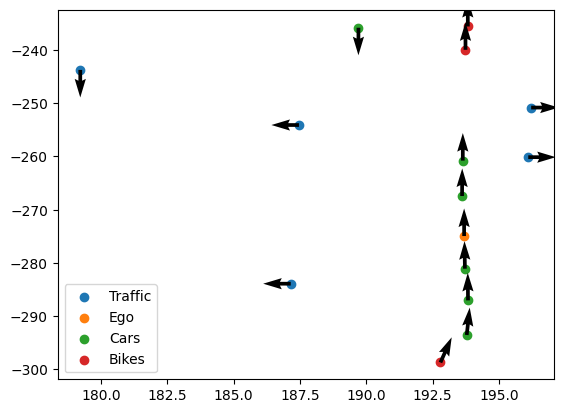

In [54]:
all_traffic = fwd_traffic + back_traffic
locs = [get_xyz(k["location"]) for k in all_traffic]
locs = np.array(locs)

directions = [get_forward_vector(get_transform(k["transform"])) for k in all_traffic]
directions = np.array(directions)

ego_loc = get_xyz(ego_data["location"])
ego_direction = get_forward_vector(get_transform(ego_data["transform"]))

car_list_locs = np.array([get_xyz(k["location"]) for k in car_list])
bike_list_locs = np.array([get_xyz(k["location"]) for k in bike_list])

car_list_directions = np.array([get_forward_vector(get_transform(k["transform"])) for k in car_list])
bike_list_directions = np.array([get_forward_vector(get_transform(k["transform"])) for k in bike_list])

if len(locs) > 0:
    plt.scatter(locs[:, 0], locs[:, 1], label = "Traffic")
    plt.quiver(locs[:, 0], locs[:, 1], directions[:, 0], directions[:, 1])

plt.scatter(ego_loc[0], ego_loc[1], label = "Ego")
plt.quiver(ego_loc[0], ego_loc[1], ego_direction[0], ego_direction[1])

if len(car_list) > 0:
    plt.scatter(car_list_locs[:, 0], car_list_locs[:, 1], label = "Cars")
    plt.quiver(car_list_locs[:, 0], car_list_locs[:, 1], car_list_directions[:, 0], car_list_directions[:, 1])

if len(bike_list) > 0:
    plt.scatter(bike_list_locs[:, 0], bike_list_locs[:, 1], label = "Bikes")
    plt.quiver(bike_list_locs[:, 0], bike_list_locs[:, 1], bike_list_directions[:, 0], bike_list_directions[:, 1])

plt.legend()
plt.show()